# Haar Wavelet

In [1]:
import numpy as np
import utils
from typing import Union
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:
class Load_Image:
    def __init__(self, image_or_path: Union[np.ndarray, str]) -> None:
        if isinstance(image_or_path, np.ndarray):
            self.image = image_or_path
        elif isinstance(image_or_path, str):
            self.image = utils.load_image(image_or_path)
        else:
            raise TypeError("Invalid type : image_or_path")
        
        try:
            self.image_grayscaled = utils.grayscaling(self.image)
        except AssertionError:
            self.image_grayscaled = self.image
    
    def imshow(self, original: bool = True):
        if original:
            utils.imshow(self.image, "Original image", False)
        else:
            utils.imshow(self.image_grayscaled, "Grayscaled image", True)
    
    def pad(self,size: tuple):
        #only pads grayscaled image
        #used to pad with zeros (0) so that the image size is a power of 2 #size : (row, col)
        row, col = self.image_grayscaled.shape
        assert row <= size[0] and col <= size[1], "Invalid size : size must be larger than the original image"
        row_pad = size[0] - row
        col_pad = size[1] - col
        self.image_grayscaled = np.pad(self.image_grayscaled, ((0,row_pad),(0,col_pad)), 'constant', constant_values=0)


(3598, 5397, 3)
(4096, 8192)


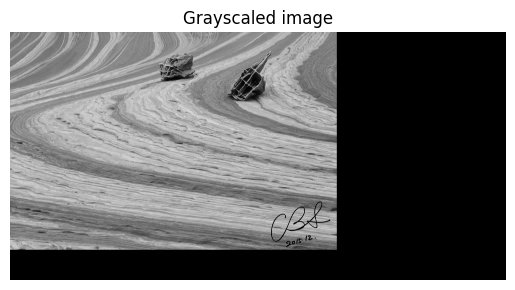

In [3]:
a = Load_Image("./Boneyard_IMG_5341.jpg")
a.pad((4096, 8192))
print(a.image.shape)

print(a.image_grayscaled.shape) #does not resize this!
a.imshow(False)


### Haar wavelet construction : use the equation below taught during class
**주의** 
밑의 n은 $2**n$할때 그 n이다. 따라서 밑의 n과는 다르다! (`get_haar_mat`에서 그래서 log취해서 함)

<img src="IMG_E49B43BAD0E8-1.jpeg" alt="Alt text" width="600" height="500">


<img src="image.png" alt="Alt text" width="450" height="200">
<img src="image-1.png" alt="Alt text" width="600" height="400">

Eqations USed
$W_n = (W_{n-1}\otimes )$

In [4]:
class HaarTransform(Load_Image):
    def __init__(self, image_or_path: Union[np.ndarray, str]) -> None:
        super().__init__(image_or_path)

    def n_to_size(self, n: int) -> int:
        return 2 ** n

    def create_zero_vector(self,n, i, value):
        """
        creates an (almost) zero vector of size n, with value at index i
        """
        vector = np.zeros(n)
        vector[i] = value
        return vector
    
    def D_n(self, size:int, n:int) -> np.ndarray :
        """
        for normalizing the haar matrix
        * size : size of the vector
        * n : n in the equation (log_2 thing)
        """
        size_log = int(np.log2(size))
        if n == 0 :
            return self.create_zero_vector(size, 0, 2**(-size_log/2)).reshape(1,size)
        else : 
            how_many = int(2**(n-1))
            left_mat = self.D_n(size, n-1)
            right_mat = np.array([self.create_zero_vector(size, x , 2**(-(size_log-(n-1))/2)) for x in range(how_many,how_many+how_many)])
            return np.concatenate((left_mat, right_mat), axis = 0)

    def get_haar_mat(self,size: int) -> np.ndarray: #! put in normalize! (with D) 
        # only allow n of power of 2 and n > 0 (check with bitwise and operator)
        assert size & (size - 1) == 0 and size >= 0, "n must be a zero or positive power of 2"
        #get n in the equation (cause 2^n = size)
        n = int(np.log2(size))

        # base case
        if n == 0:
            return np.array([[1]])
        else : 
            # recursive case, use np.kron to get kronecker product
            left_mat = np.kron(self.get_haar_mat(self.n_to_size(n - 1)), np.array([[1], [1]])) #reason for [[1],[-1]] : to make it explicilty into column vector
            right_mat = np.kron(np.eye(self.n_to_size(n - 1)), np.array([[1], [-1]]))
            return np.concatenate((left_mat, right_mat), axis = 1) 
    
    def normalize(self, haar_mat: np.ndarray) -> np.ndarray:
        W_n = haar_mat
        size = W_n.shape[0]
        n = int(np.log2(size))
        H_n = W_n@self.D_n(size, n)
        return H_n
    
    def haar_transform_2d(self, size: tuple, img : np.ndarray) -> np.ndarray:
        x_size, y_size = size
        normalized_haar_mat_x = self.normalize(self.get_haar_mat(x_size))
        normalized_haar_mat_y = self.normalize(self.get_haar_mat(y_size))
        transformed_2d = (normalized_haar_mat_x.T)@img@normalized_haar_mat_y
        return transformed_2d

    def compress_matrix(self, percentage, matrix : np.ndarray, take_abs = True) -> np.ndarray:
        """ 
        compresses the matrix by setting the values below percentage to 0
        * percentage : percentage of the values to keep
        * matrix : matrix to compress (expected to be haar transformed matrix)
        * take_abs : whether compress based on absolute value or remove FROM negative values (i.e. |mask| > threshold or mask > threshold)
        """
        size = matrix.shape
        x_size, y_size = size
        if take_abs:
            threshold = np.percentile(np.abs(matrix), percentage)
            mask = np.abs(matrix) > threshold
        else : 
            threshold = np.percentile(matrix, percentage)
            mask = matrix > threshold
        matrix_compressed = matrix * mask       
        return matrix_compressed
    
    def compress_freq(self):
        print("DO THIS DO TYHIS")
        raise NotImplementedError("DO THIS DO TYHIS")
        #! DO THIS!

    def inverse_haar_transform_2d(self, size: tuple, img_trans : np.ndarray, to_unit8 = True) -> np.ndarray:
        """ 
        inverse haar transform
        * size : size of the image (transformed haar matrix)
        * img_trans : transformed image (after haar transform)
        * to_unit8 : whether to convert to unit8 (for displaying purposes)
        """
        x_size, y_size = size
        normalized_haar_mat_x = self.normalize(self.get_haar_mat(x_size))
        normalized_haar_mat_y = self.normalize(self.get_haar_mat(y_size))
        transformed_2d = (normalized_haar_mat_x)@img_trans@(normalized_haar_mat_y.T)
        return transformed_2d.astype(np.uint8) if to_unit8 else transformed_2d
    

    # def compress_partial_enc_dec(self, img):
    #     """
    #     * compress image by halving thing
    #     """
    #     x_size, y_size = img.shape
    #     x_bound, y_bound = x_size//2, y_size//2
    #     normalized_haar_mat_x = self.normalize(self.get_haar_mat(x_size))
    #     normalized_haar_mat_y = self.normalize(self.get_haar_mat(y_size))

    #     #get partial haar matricies 
    #     HX_L = normalized_haar_mat_x[:, :x_bound]
    #     HX_H = normalized_haar_mat_x[:, x_bound: ]
    #     HY_L = normalized_haar_mat_y[:, :y_bound]
    #     HY_H = normalized_haar_mat_y[:, y_bound: ]
    #     print(HX_L.shape, HX_H.shape, HY_L.shape, HY_H.shape)

    #     #transform through partial haar matricies
    #     img_transformed_LL = (HX_L.T)@img@(HY_L)
    #     img_transformed_LH = (HX_H.T)@img@(HY_L)
    #     img_transformed_HL = (HX_L.T)@img@(HY_H)
    #     img_transformed_HH = (HX_H.T)@img@(HY_H)
    #     print(img_transformed_LL.shape, img_transformed_LH.shape, img_transformed_HL.shape, img_transformed_HH.shape)

    #     #reconstruct partial transformed images
    #     img_LL = (HX_L)@img_transformed_LL@(HY_L.T)
    #     img_LH = (HX_H)@img_transformed_LH@(HY_L.T)
    #     img_HL = (HX_L)@img_transformed_HL@(HY_H.T)
    #     img_HH = (HX_H)@img_transformed_HH@(HY_H.T)
    #     print(img_LL.shape, img_LH.shape, img_HL.shape, img_HH.shape)

    #     return img_LL, img_LH, img_HL, img_HH


def crop_out_padded_part(img):
    return img[0:3598, 0:5397]

#  Haar 로 보낸후 top x%의 값들만 남기고 다시 reconstruction 하기 => 이건 잘됨!

In [5]:
haar = HaarTransform("./Boneyard_IMG_5341.jpg")
power_2_shape = (4096, 8192)
haar.pad(power_2_shape)
padded_image = haar.image_grayscaled
transformed_img = haar.haar_transform_2d(size=power_2_shape, img=padded_image)
compression_percentages = {
    "50%": 50,
    "10%": 90,
    "1%": 99,
    "0.1%": 99.9,
    "0.05%": 99.95,
    "0.01%": 99.99,
    "0.008%": 99.992,
    "0.006%": 99.994,
    "0.004%": 99.996,
    "0.002%": 99.998,
    "0.001%": 99.999,
    "0.0008%": 99.9992,
    "0.0006%": 99.9994,
    "0.0004%": 99.9996,
    "0.0002%": 99.9998,
    "0.0001%": 99.9999,
    "0.00008%": 99.99992,
    "0.00006%": 99.99994,
    "0.00004%": 99.99996,
    "0.00002%": 99.99998,
    "0.00001%": 99.99999,
    #"0.000001%": 99.99999,
}


reconstructed_images = {}

for percentage, value in compression_percentages.items():
    transformed_img_compressed = haar.compress_matrix(value, transformed_img)
    reconstructed_img = haar.inverse_haar_transform_2d(size=power_2_shape, img_trans=transformed_img_compressed)
    reconstructed_images[percentage] = reconstructed_img
    #reconstructed_images[percentage] = crop_out_padded_part(reconstructed_img)


In [6]:
##이미지를 특정 부분만 본다던지 하기위해서 밑아와같이 다양한 것을 저장하기 

#original padded reconstructed img
original_image = padded_image

#pads removed img
cropped_original_image = crop_out_padded_part(original_image)
cropped_reconstructed_images = {percentage: crop_out_padded_part(reconstructed_image) for percentage, reconstructed_image in reconstructed_images.items()}

#looking at specific portion of the image, at the waffle looking thing
cropped_original_image_specific = original_image[550:1150,3600:4200]
cropped_reconstructed_images_specific = {percentage: reconstructed_image[550:1150,3600:4200] for percentage, reconstructed_image in reconstructed_images.items()}


#looking at specific portion of the image,near the border
cropped_original_image_specific_2 = original_image[3588:3608, 5387:5407]#[3450:3700,5250:5500]
cropped_reconstructed_images_specific_2 = {percentage: reconstructed_image[3588:3608, 5387:5407] for percentage, reconstructed_image in reconstructed_images.items()}

In [7]:
def plot_images(cropped_original_image, reconstructed_images, figsize=(14, 14), line_in_center = False):
    # Create a 6x4 subplot
    fig, axs = plt.subplots(6, 4, figsize=figsize)

    # Plot the original image
    axs[0, 0].imshow(cropped_original_image, cmap='gray')
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis('off')
    if line_in_center:
        axs[0,0].axvline(x=cropped_original_image.shape[1] // 2 , color='red', linestyle='--', linewidth=3)
        axs[0,0].axhline(y=cropped_original_image.shape[0] // 2  , color='red', linestyle='--', linewidth=3)


    # Iterate over the reconstructed_images and plot them in the subplots
    for i, (percentage, img) in enumerate(reconstructed_images.items()):
        # Remove the percentage sign from the string
        percentage = percentage.rstrip('%')

        row = (i + 1) // 4
        col = (i + 1) % 4
        axs[row, col].imshow(img, cmap='gray')
        axs[row, col].set_title(percentage + '%')
        axs[row, col].axis('off')
        if line_in_center:
            axs[row, col].axvline(x=img.shape[1] // 2 , color='red', linestyle='--', linewidth=3)
            axs[row, col].axhline(y=img.shape[0] // 2  , color='red', linestyle='--', linewidth=3)

    # # Remove empty subplots
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)  # Adjust the hspace parameter to change the space between rows
    plt.axis('off')

    # Add the following code to prevent the last plot from being removed
    for i in range(len(reconstructed_images)+2 , 24):
        row = (i - 1) // 4
        col = (i - 1) % 4
        fig.delaxes(axs[row, col])

    plt.show()

Analysis : (padded image자체를 보기)
* 눈으로 보았을때는, 거의 1% 전까지는 괜찮아보임
* 압축률이 늘어나며 padded된 부분의 값들이 0에서, 0,1 값중 하나를 가지게 됨. 0,1중 하나를 가지는 이유는 해당 wavelet의 amplitude가 compression을 하며 0으로 되어, 0 또는 1만의 값을 가지기 때문이라고 생각함 (원래 haar wave 자체가 0과 1사이의 값중 하나만 가지니)


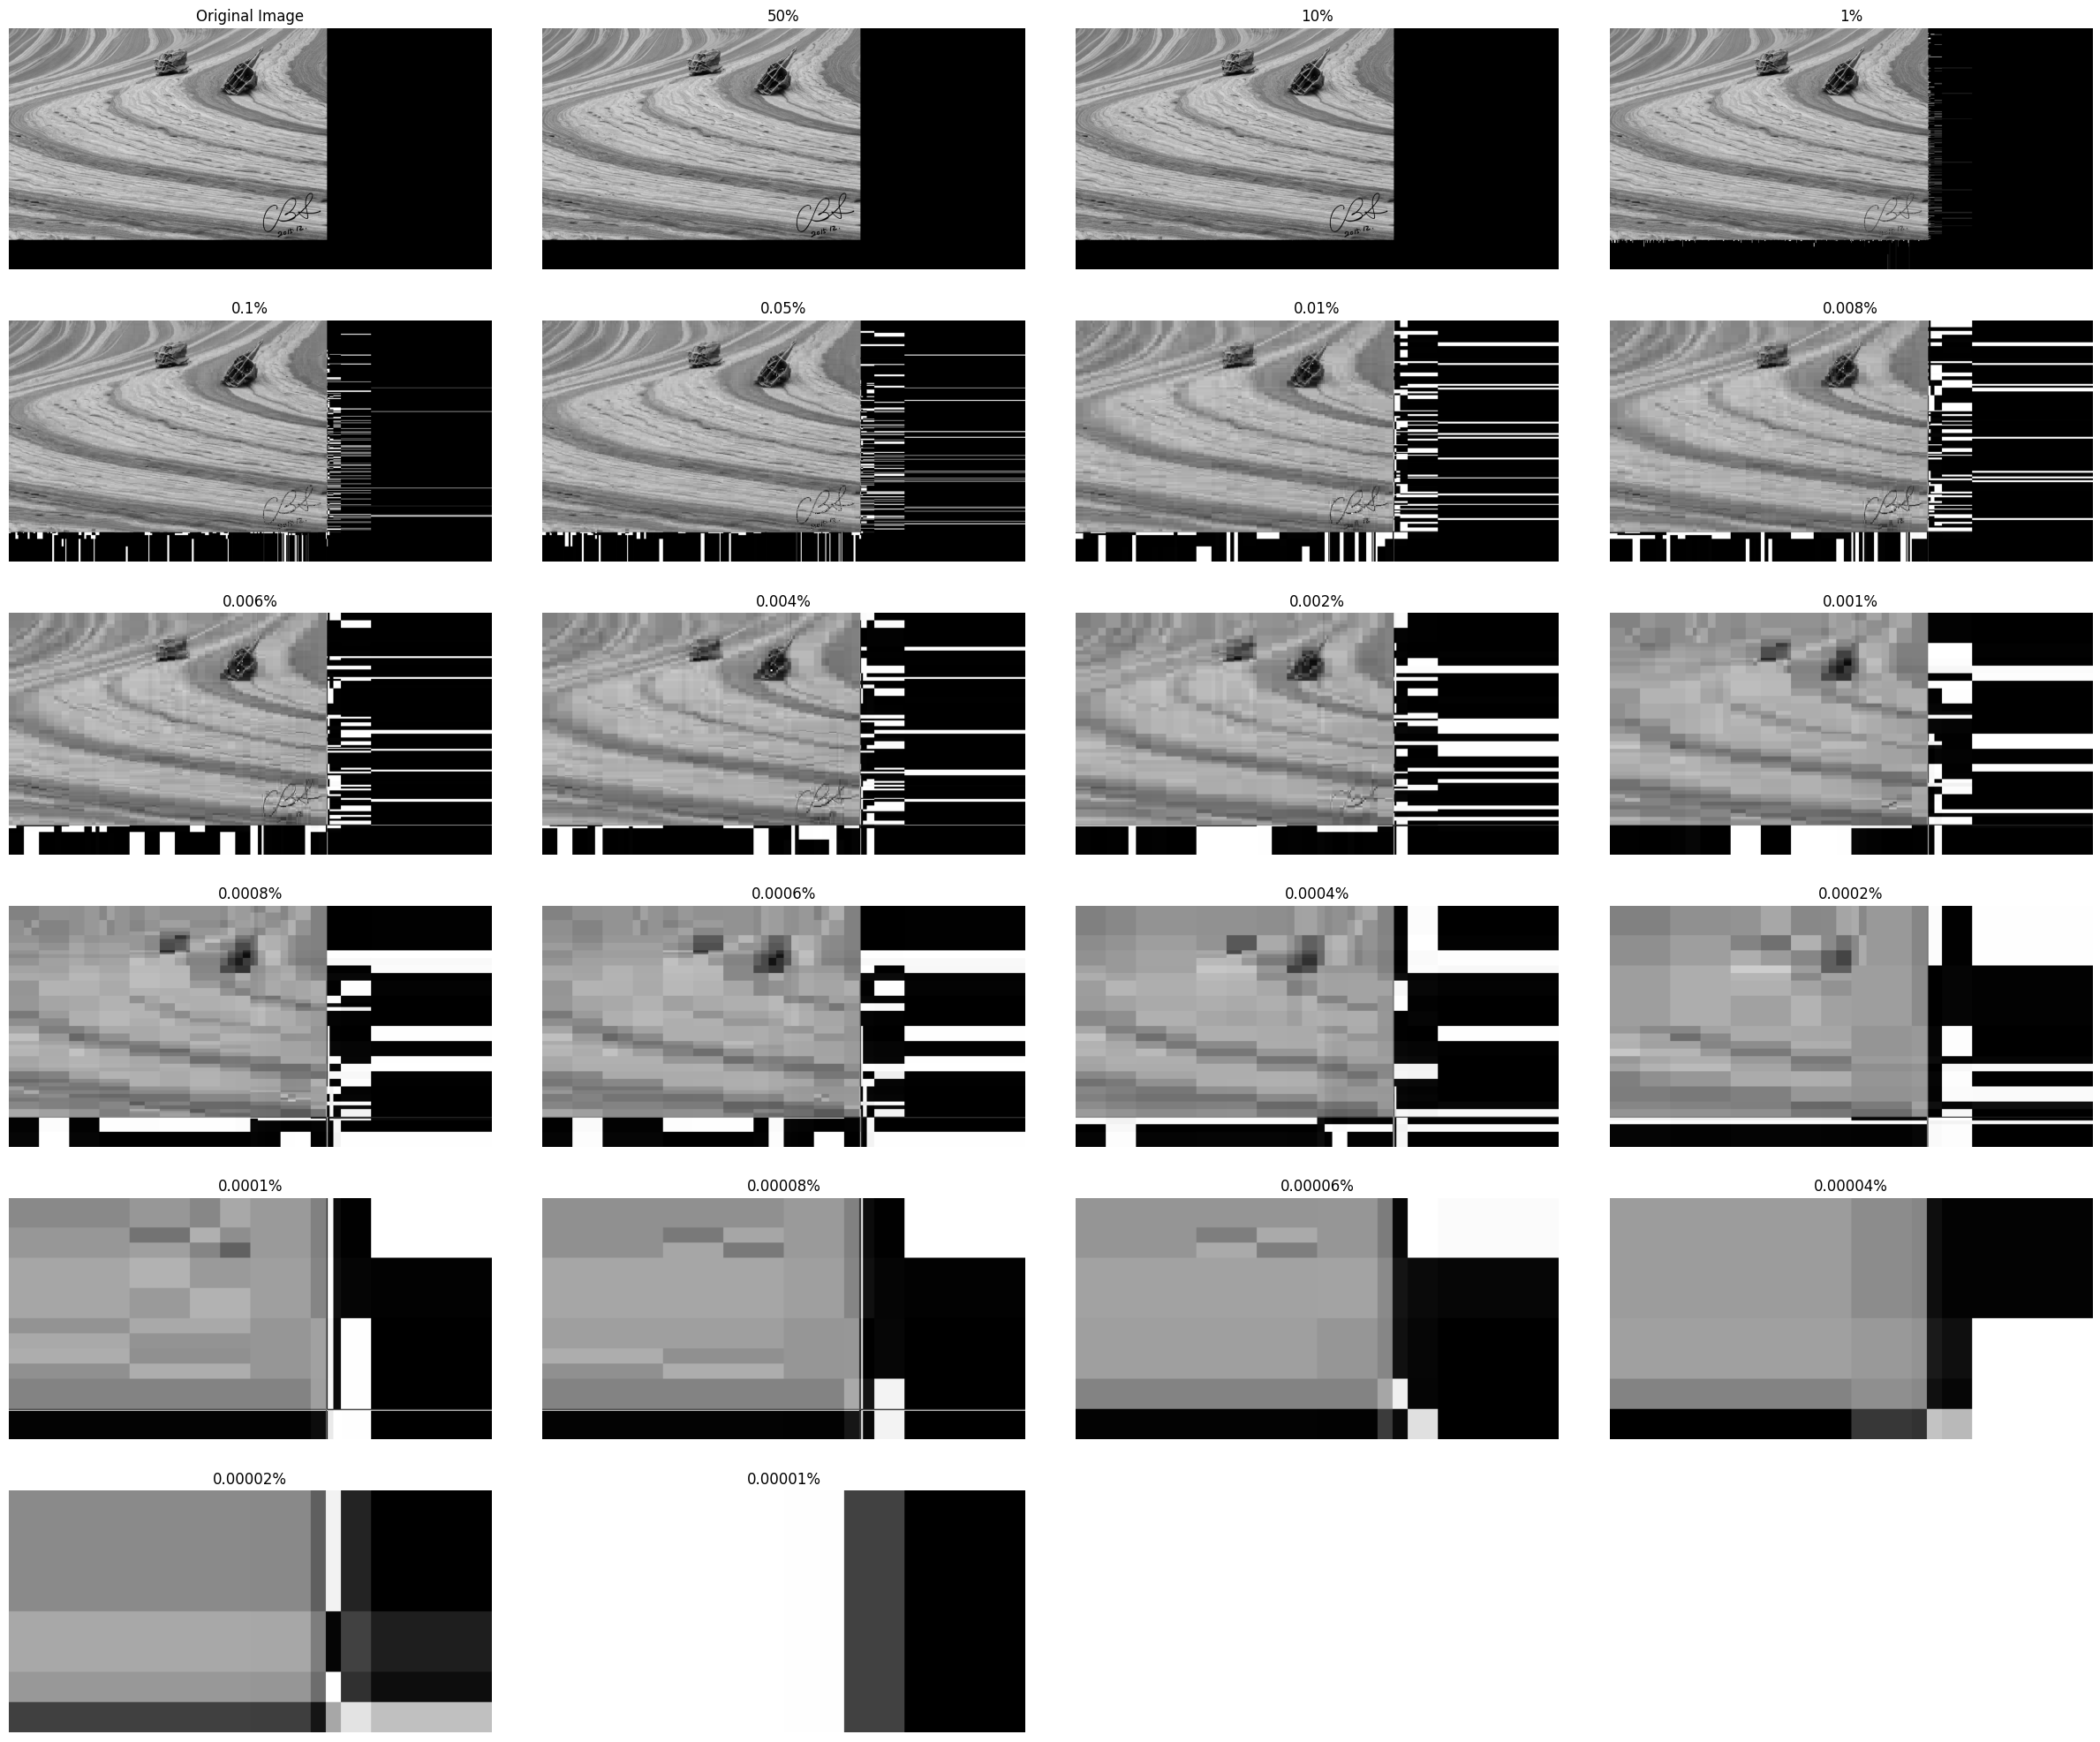

In [8]:
# Call the function with the desired images
plot_images(original_image, reconstructed_images, figsize=(24, 20))


Analysis : cropped image (i.e. 원래 압축하고자 했던 이미지) 의 부분을 보기
* 전반적인 이미지는 1%가 될떄까지도 잘 유지한 것을 알 수 있음
* 하지만, CBS 교수님의 사인은 1%에서부터 연해짐. 이 이유는 아마도 싸인 자체가 매우 얇기 떄문에, low frequency haar amplitude에 큰 영향을 끼치지 못하여, detail to be dropped에 해당되게 되어 그렇게 된것으로 보여짐.
* 0.0001%의 reconstructed image를 보면, pixelated된 격자들의 간격이 일정하지 않다는 것을 알 수 있음. 특히, waffle이 있던 근처의 격자들 간격이 좁다는 것을 알 수 있음. 이는 다음과 같은 이유라고 생각됨 :
    * 원래 이미지를 보면 알 수 있듯이, 두개의 와플이 있는 구간은 주위 배경와 명암차이가 심함 (즉, 주위보다 갑자기 많이 어두워짐). 따라서, 와플 크기 정도의 haar wavelet의 amplitude가 클것이라는 것을 알 수 있음. 따라서, 이 격자간격을 가진 것이 계속 보존되는 것 같음. 
* 0.0001% 사진을 보면 이미지의 오른쪽에 boundary에 아주 얇은 검은색 bar이 있는 것을 알 수 있음. 실제로 이 bar의 크기와명암이 압축률이 높아질수록 커진다는 것을 볼 수 있음. 이는 다음과 같은 이유라고 생각 됨 : 
    * Haar wavelet transform을 하기위해서 이미지에 0을 padding해서 2의 제곱수로 만들어주었어야 했음. 따라서, 이미지의 boundary와 padding된 0사이에는 아주 큰 픽셀값 차이가 나타나개 됨. 따라서, 이 파트의 haar wavelet amplitude가 클 것임. 따라서, 압축률이 높아도, 이 boundary에서 존재하는 large haar wavelet amplitude가 유지되게 되고, 이것이 압축률이 높은 이미지에서 나타나는 것으로 보임. 실제로, 위의 "padded image자체를 보기" 파트를 자세히 보면, 압축률 0.00008%의 경우 이미지 바운더리 근처에 큰 흰색 선이 보임. 이것이 앞서 언급한 border discontinuity에 의한 large haar wavelet amplitude가 유지되면서 일어나는 현상같음.
    * 이런 artifect를 없애기 위해서, 다음에는 이미지를 padding할때 0을 패딩하는 것이아닌 boundary padding을 해야할 것으로보임

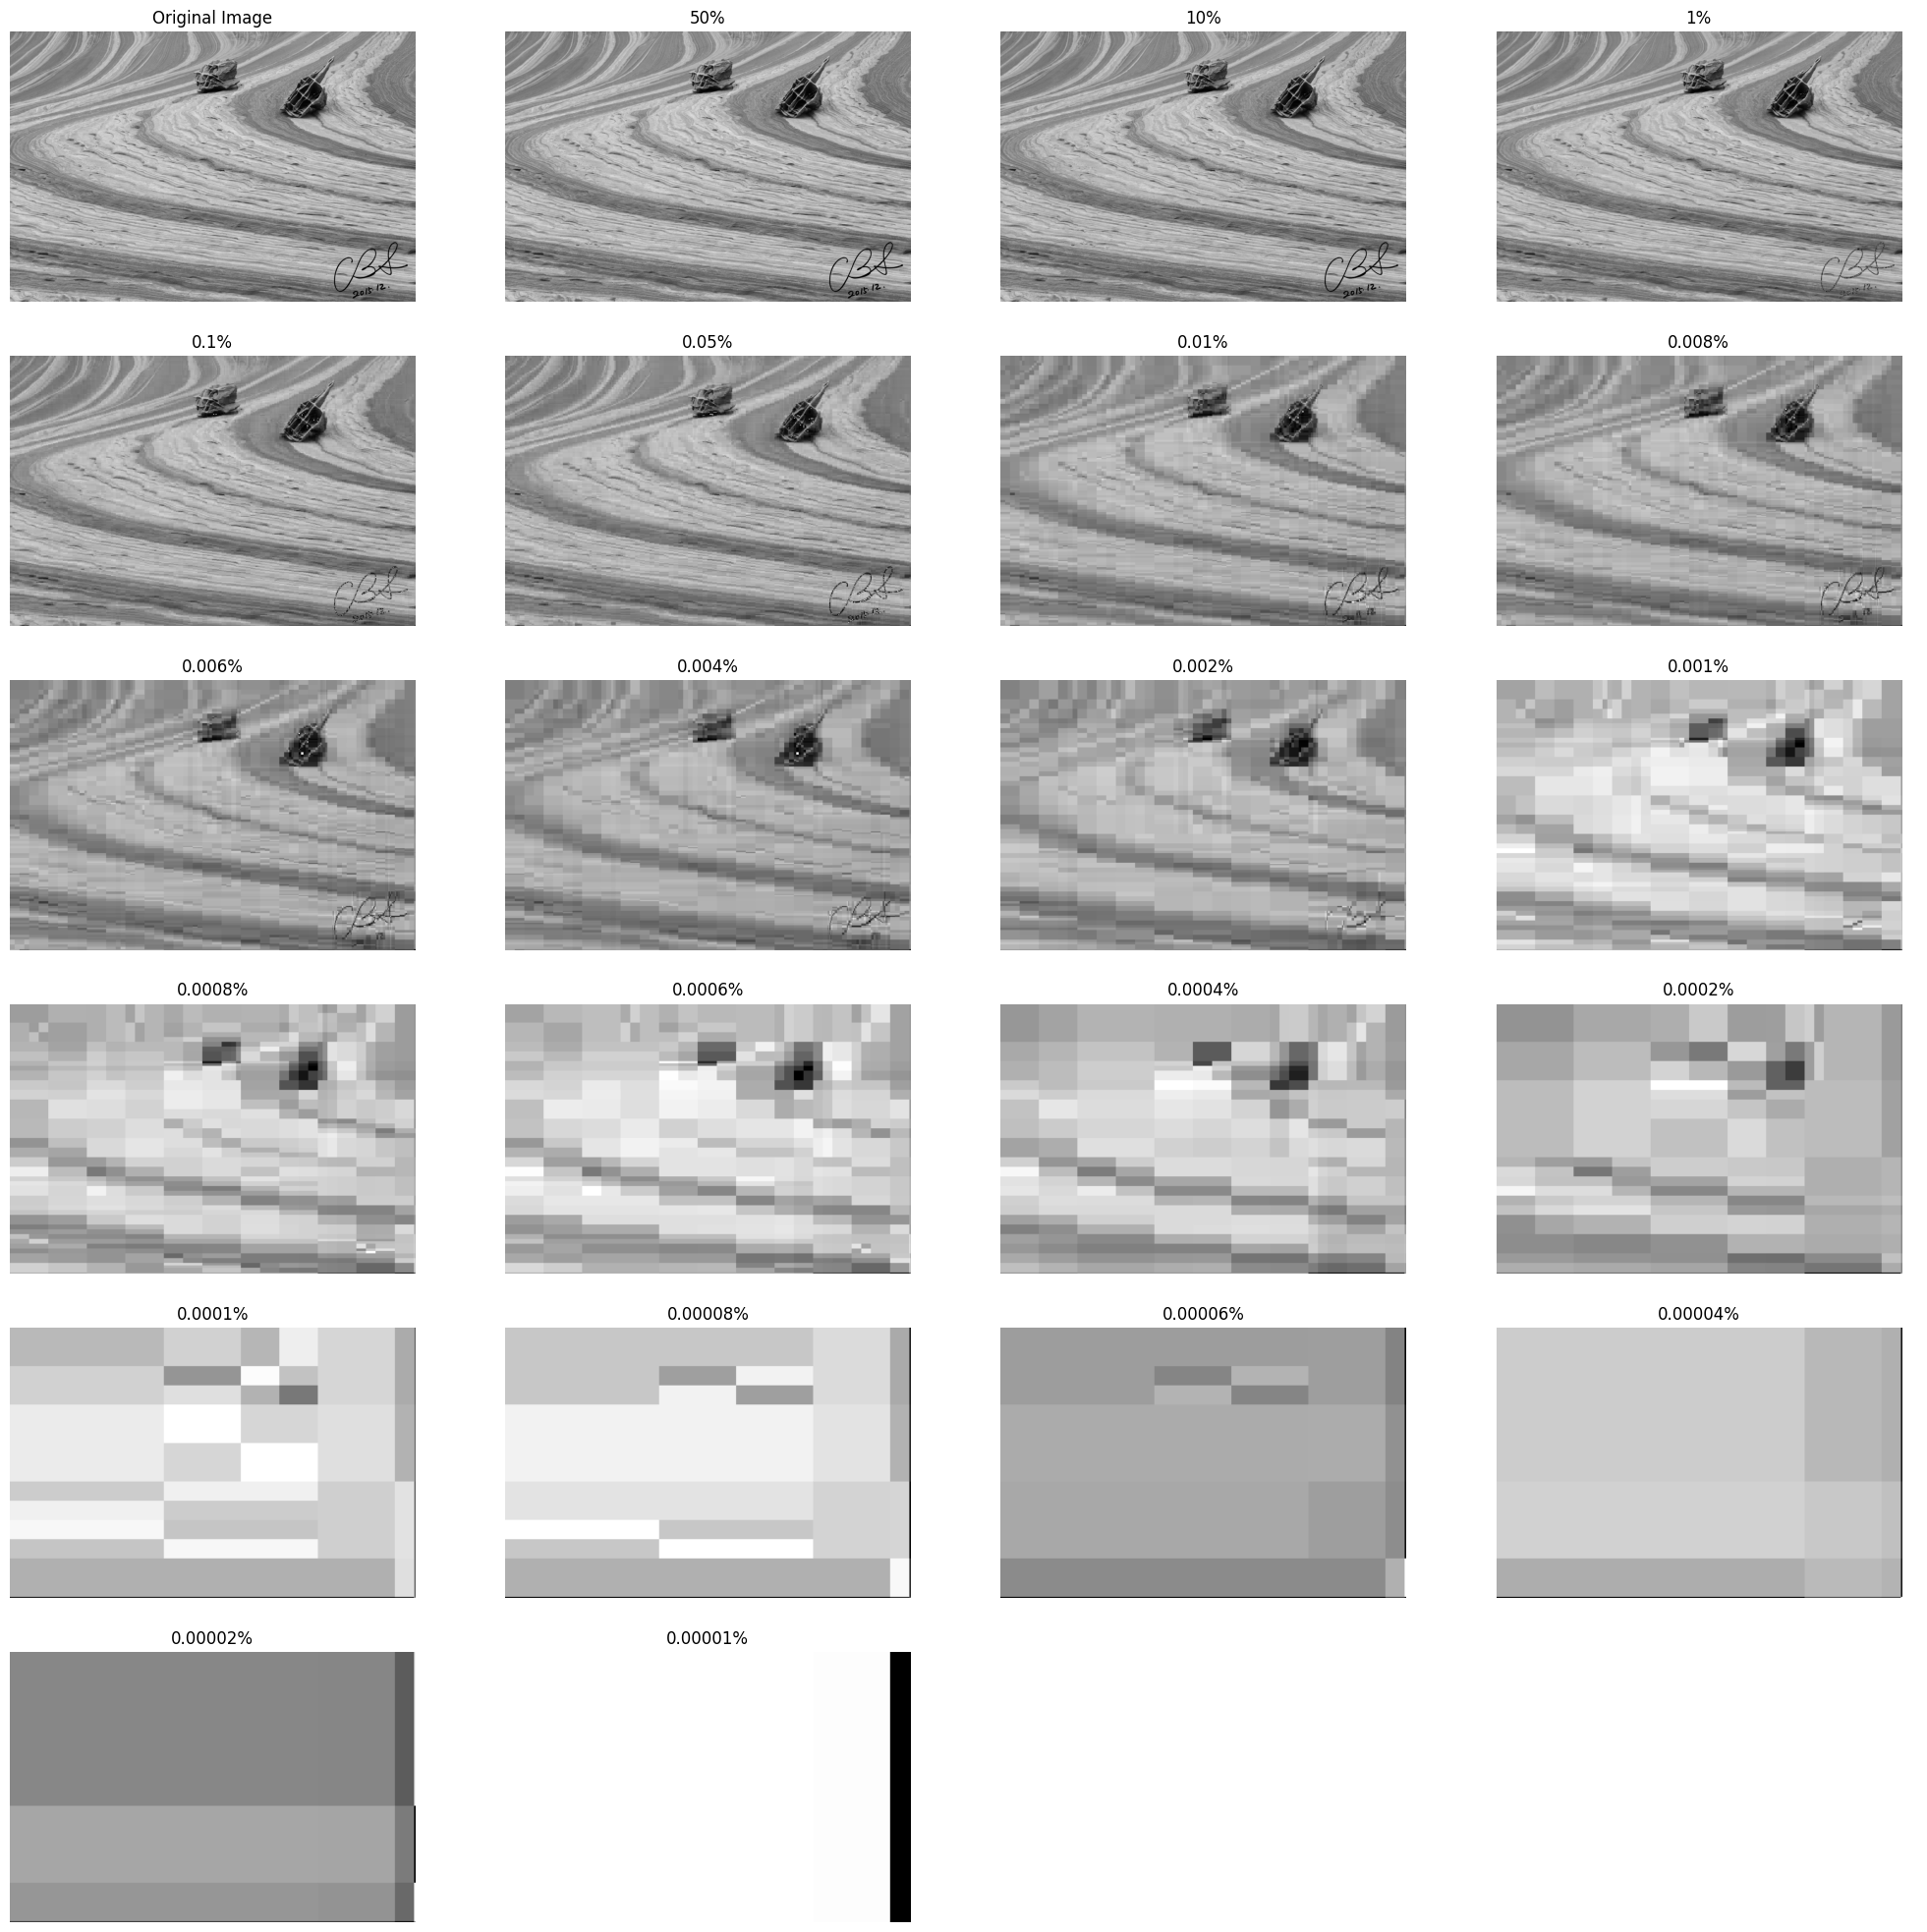

In [9]:
plot_images(cropped_original_image, cropped_reconstructed_images, figsize=(20,20))


Analysis : 와플모양에 집중하기 : 와플모양에 집중한 사진을 보면 특이점을 몇가지 볼 수 있음
* 압축률이 증가하면서 (특히 1%부터) 와플의 검은색 부분에, 없어야하는 흰색이 나타나기 시작함. 이는 두가지 이유때문이라고 생각을 함. 
    1. 검은색 부분은 픽셀값들이 0에 가깝기 떄문에, 그 안에서 조금만 값이 0에서 벗어나면 두드러져 보이게 될 것임. 따라서, 어쩌면 압축률을 높이면서 자연스럽게 나타나는 noise가 와플내의 검은색부분에서 돋보이는 것일 수도 있음
    2. 와플내의 검은색 부분은 애당초 명암차이가 별로 없기때문에, haar wavelet amplitude가 적고, 따라서 압축률을 높일때 detail이 죽어버리게 됨. 그런데 haar wavelet의 값은 0또는 1만 가짐으로, 해당 디테일이 사라져서 저렇게 1로 중간중간 흰색 부분이 보이는 듯함.



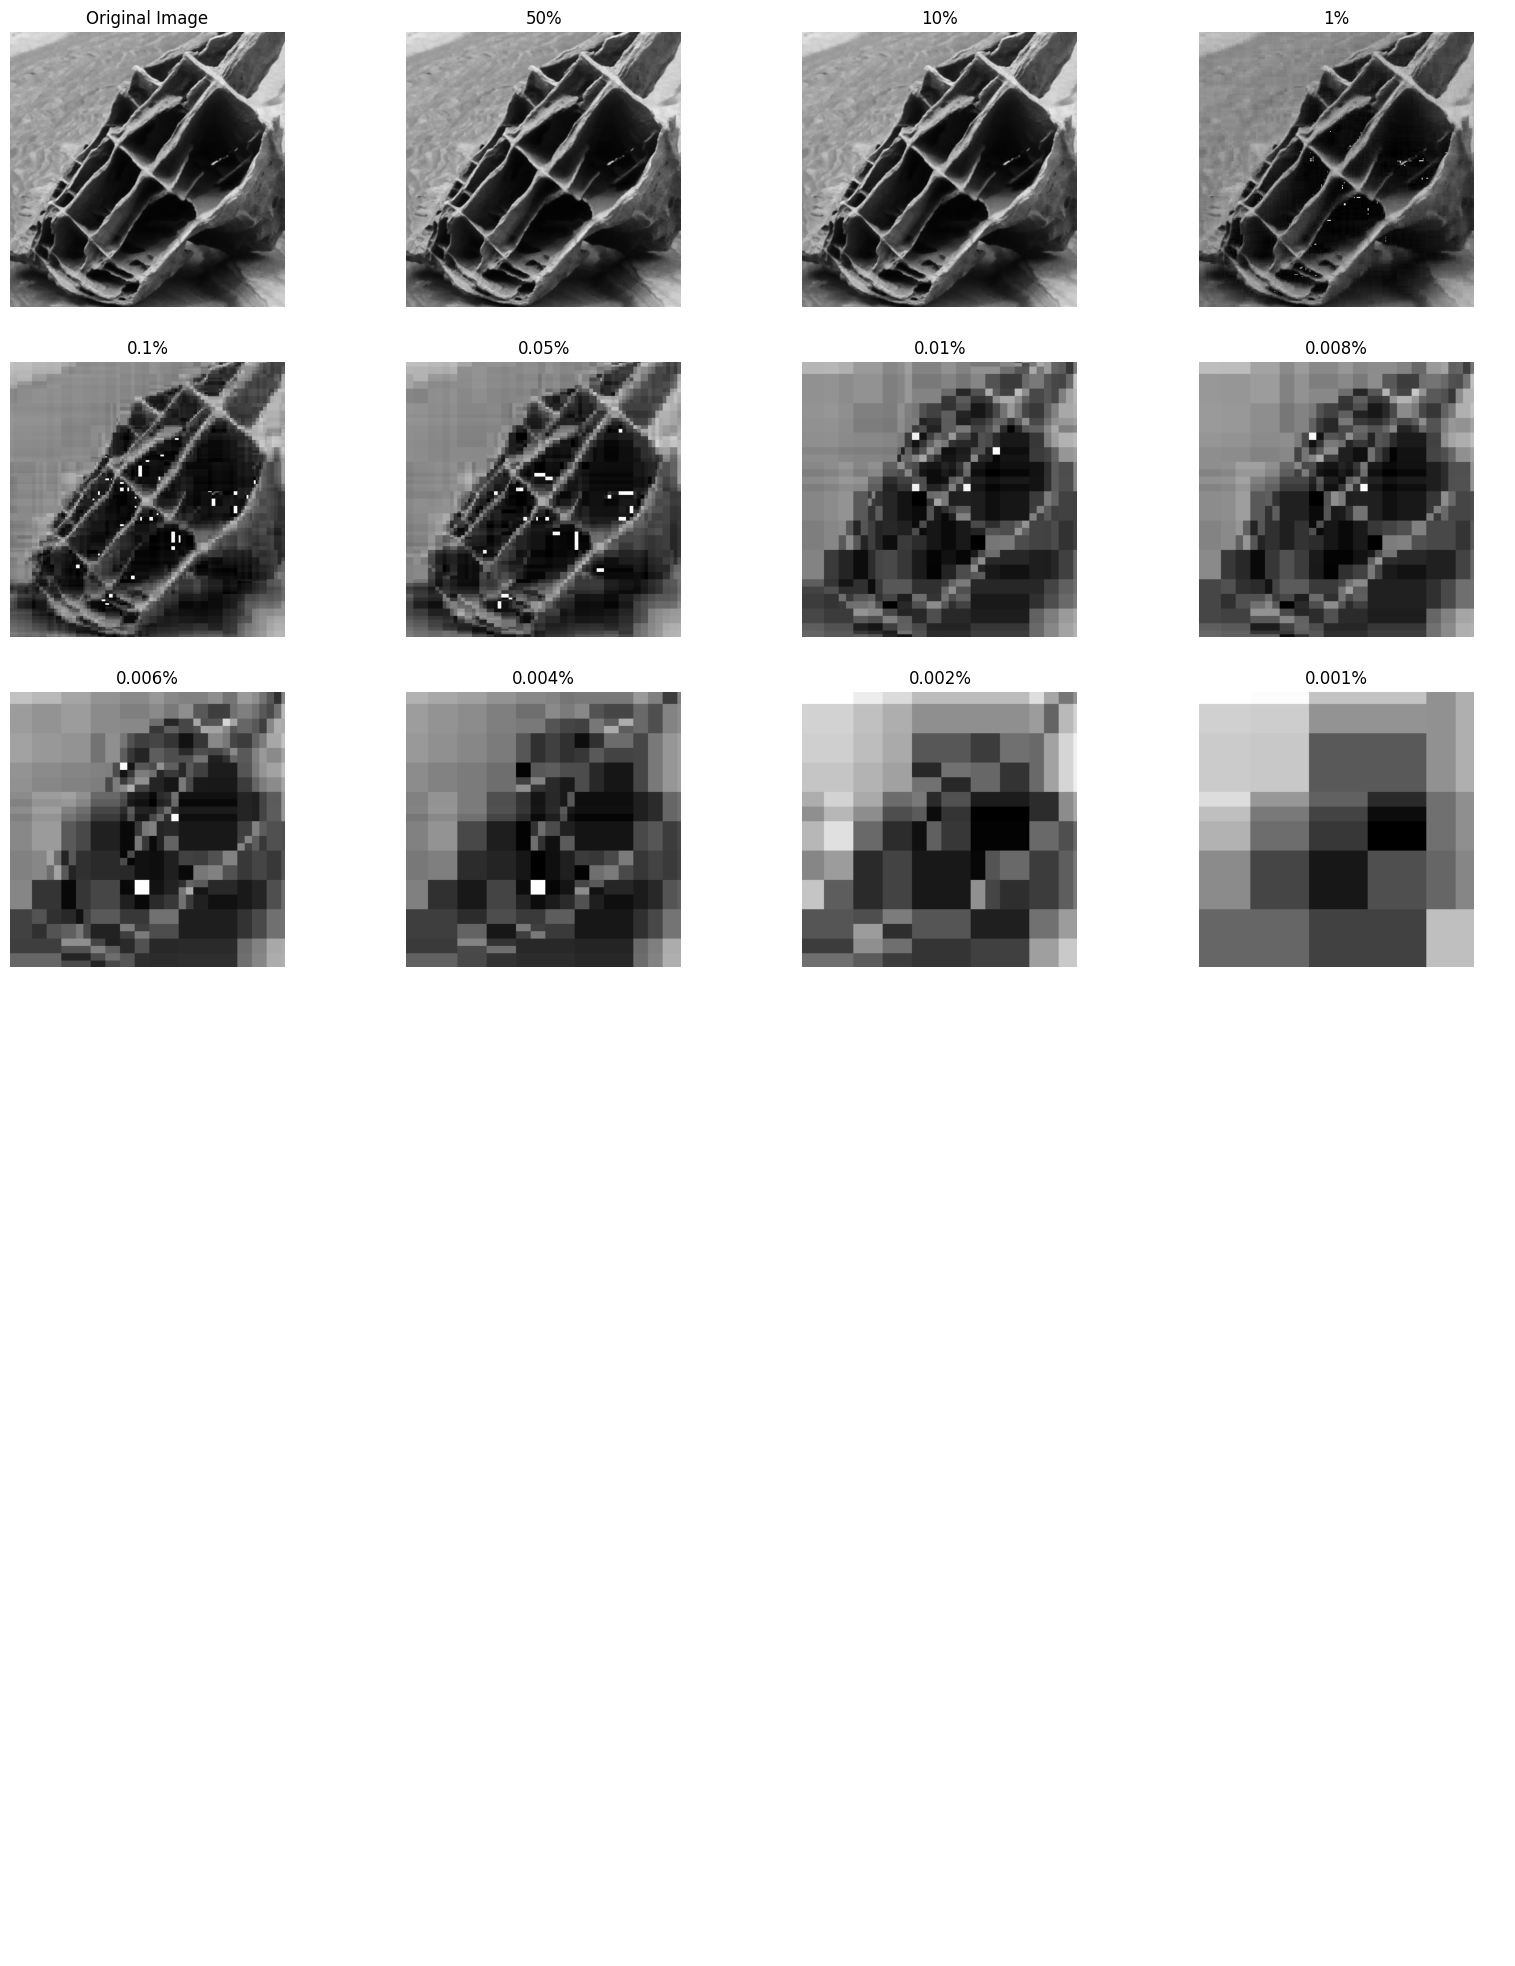

In [10]:
new_dict = cropped_reconstructed_images_specific.copy()

for _ in range(10): #remove last 10 items!
    new_dict.popitem()

plot_images(cropped_original_image_specific, new_dict, figsize=(16,20))



Analysis : 앞서 언급한 boundary에서의 discontinuiuty에 의해서 생겨나는 artifect를 저 자세히 보기위해서 이미지의 boundary부분만 확대해 보았습니다. (총 이미지중 padded된 부분의 모서리로 41x41이미지 입니다)
* 먼저, boundary기준으로 reconstructed된 값들의 차이가 discontinuous하다는 것을 볼 수 있습니다. 이는, 이미 예상된 결과입니다.
* 하지만, 압축률이 1%보다 높아지게 되면, 앞서언급한 discontinuity가 극심히 보이기 시작합니다. 실제로, 

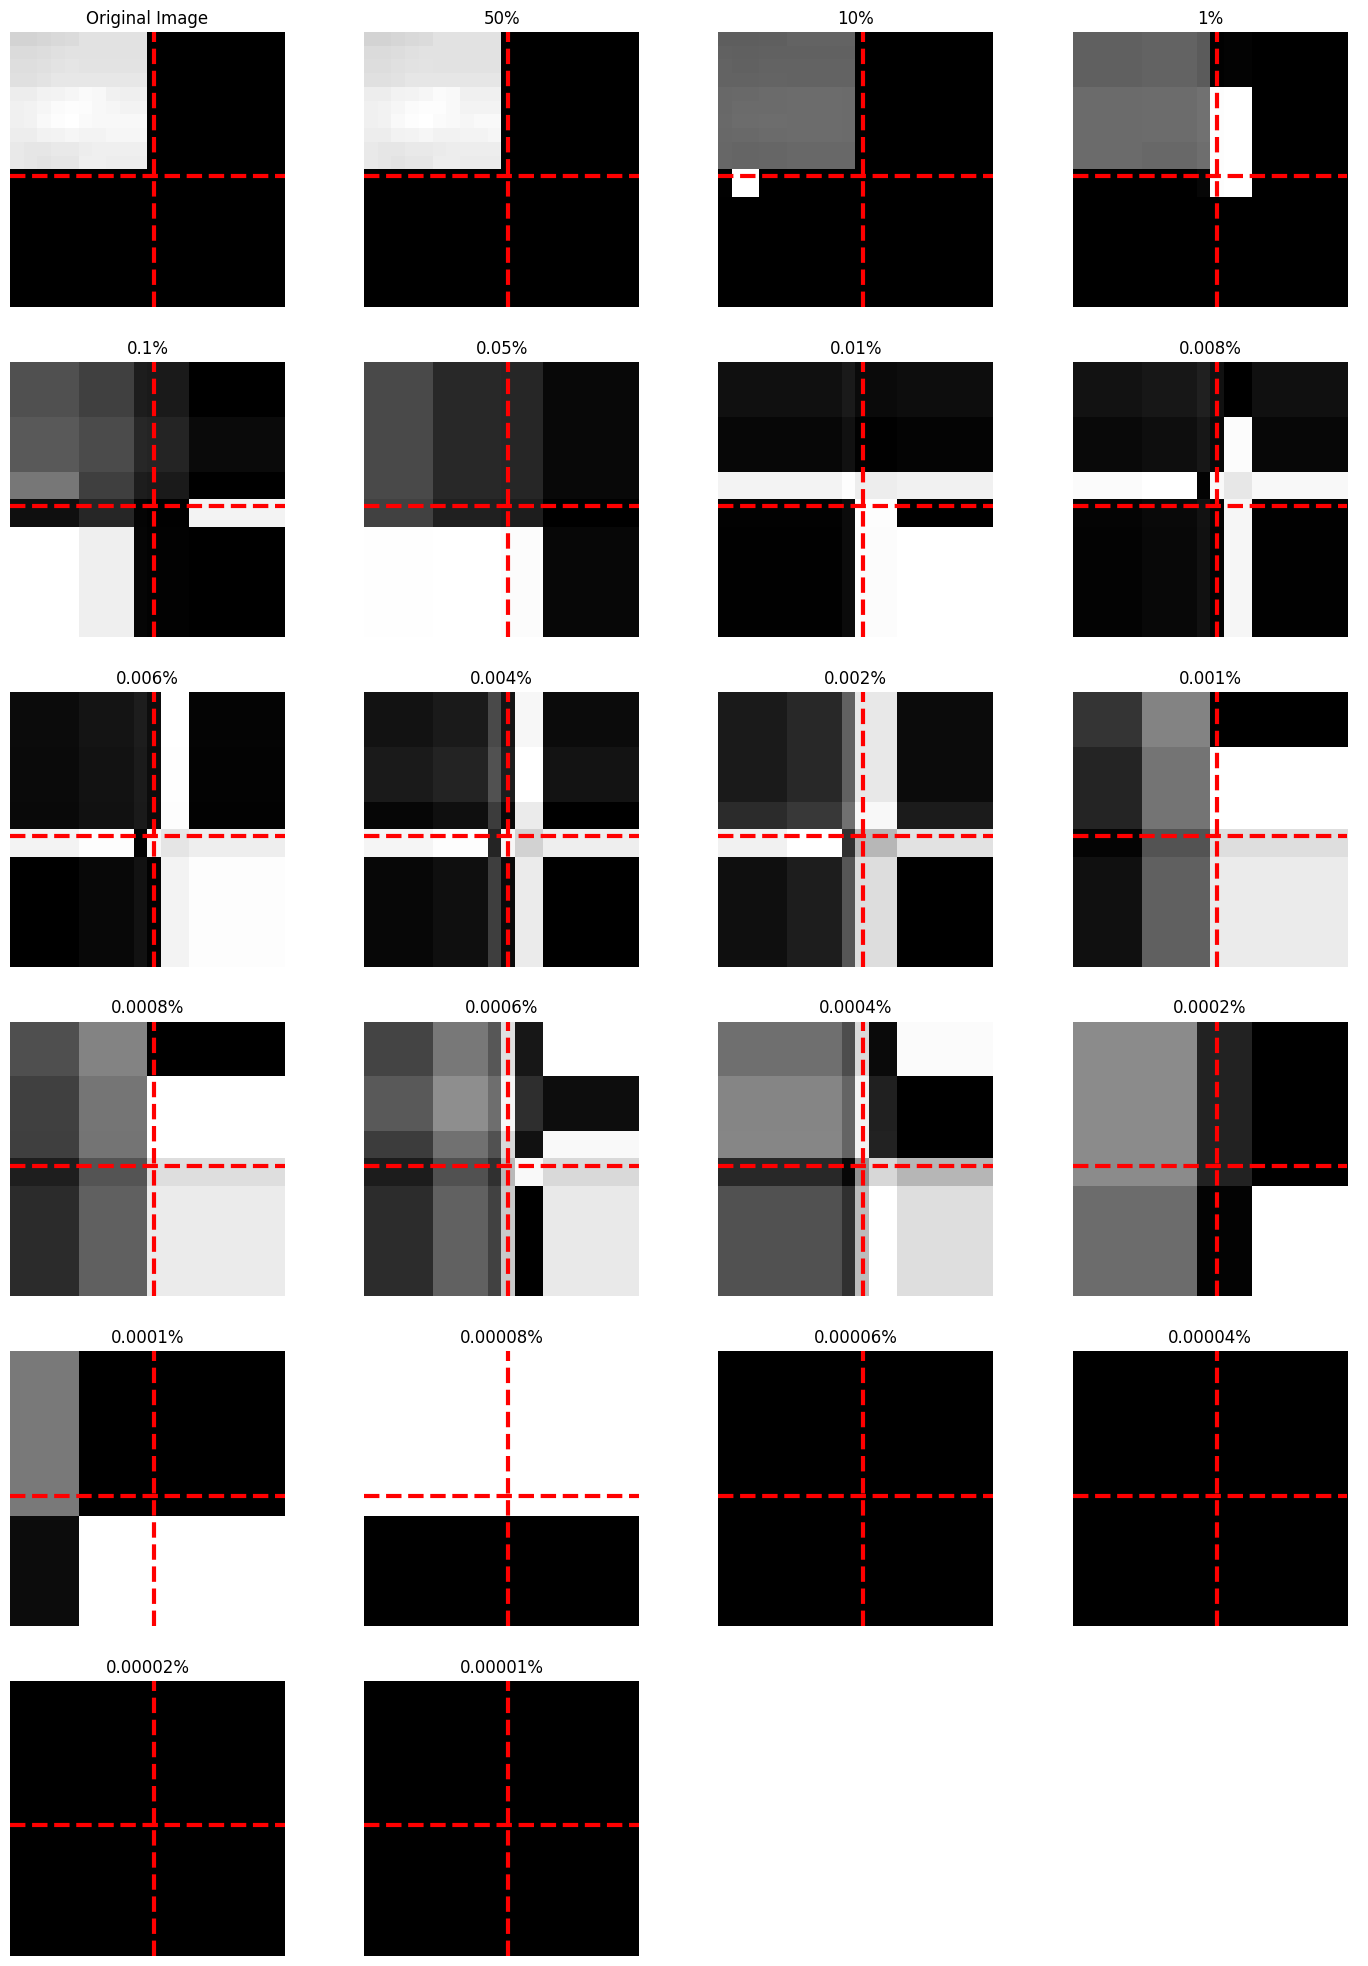

In [11]:
plot_images(cropped_original_image_specific_2, cropped_reconstructed_images_specific_2, figsize=(14,20), line_in_center=True)

밑은 RMSE값들을 plotting한것입니다 (for a given 압축률)
보시다시피, RMSE loss는 압축률이 높아질수록 기하급수적으로 증가하는 것을 볼 수 있습니다. 

[0.5, 0.9, 0.99, 0.999, 0.9995, 0.9999, 0.99992, 0.99994, 0.99996, 0.99998, 0.99999, 0.999992, 0.999994, 0.999996, 0.999998, 0.999999, 0.9999992, 0.9999994, 0.9999996, 0.9999998, 0.9999999] [0.0023214377201077846, 0.008456574328934112, 0.037312141246789304, 0.05228655408459112, 0.05815733351154806, 0.07136556396755049, 0.0732414735000235, 0.07653947136105238, 0.08047954180186846, 0.08756099010828454, 0.09539615195889493, 0.09780118842711322, 0.10128935123679722, 0.10609187731700084, 0.11582692422958293, 0.12750490762945124, 0.13186681289249375, 0.136929285925454, 0.14227294337848229, 0.15826335587588458, 0.1842692615236502]


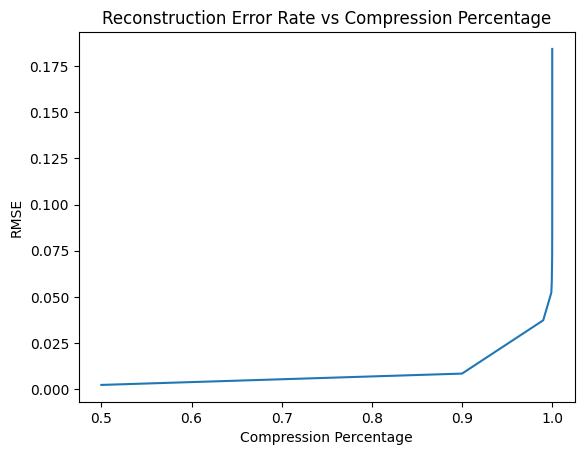

In [12]:
def calculate_rmse(image1, image2):
    # Normalize pixel values to the range of 0 to 1
    image1 = image1 / 255.0
    image2 = image2 / 255.0

    # Calculate MSE
    mse = np.mean((image1 - image2) ** 2)

    # Calculate RMSE
    rmse = np.sqrt(mse)

    return rmse



mse = []
x_values = []

for percentage, img in reconstructed_images.items():
    cropped_img = crop_out_padded_part(img)
    mse.append(calculate_rmse(cropped_original_image, cropped_img))
    x_values.append(1-0.01*float(percentage.rstrip('%')))  # Remove the percentage sign
print(x_values, mse)
plt.plot(x_values, mse)
plt.xlabel("Compression Percentage")
plt.ylabel("RMSE")
plt.title("Reconstruction Error Rate vs Compression Percentage")
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(-0.01, 0.2)
plt.show()


Analysis : 밑의 그림은 original, 1%, 0.01%로 압축을 했을때 각각의 reconstructed image의 pixel값 histogram을 본것입니다. 
* as expected, 압축율이 높아질수록 reconstructed image가 원래 이미지와 많은 차이가 난다는 것을 알 수 있습니다.
* 또한, 0~0.1사이의 픽셀값들만 본 두번째 히스토그램의 경우, 원래 있던 검은색 픽셀이 많이 사라지는 것을 볼 수 있습니다. 1%압축율 이미지의 경우, 이것은 CBS라고 검은색으로 싸인한 부분이 연해지기 때문인 것으로 보입니다. 
* 세번째 히스토그램의 경우, 0.01%로 압축된 것의 경우 histogram이 균일하지 않은 것을 볼 수 있는데, 이는 압축율이 너무 높아 그런 것 같습니다.
* 마지막 히스토그램의 경우 (0.8~1.0 구간), 원래의 이미지에는 없던, 높은 픽셀값들이 생긴다는 점을 볼 수 있다. 이는 아마도 wavelet amplitude갯수가 적어져서, 특정 픽셀값이 amplitude가 모두 0인 wavelet들로 이루어지는 경우가 생기는데, 이렇게 되면 haar wavelet의 원래 값인 0 또는 1중 하나를 가질 가능성이 높아져서 그렇게 보인다 


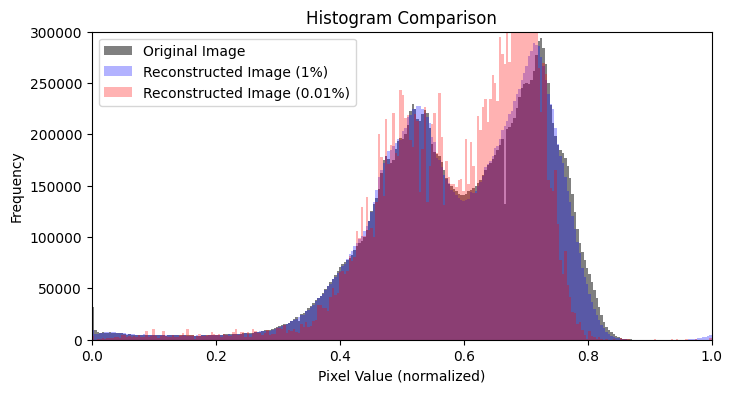

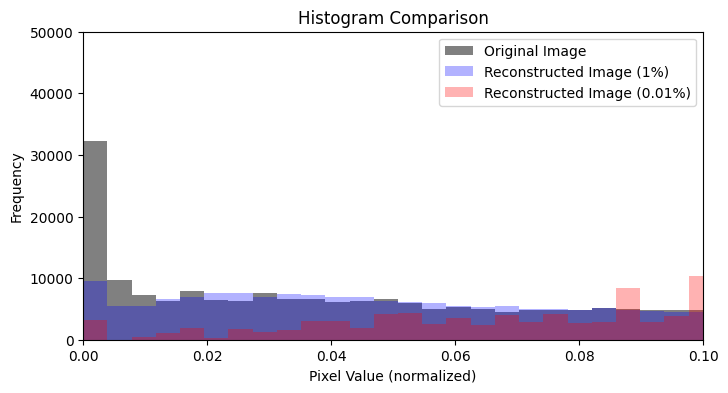

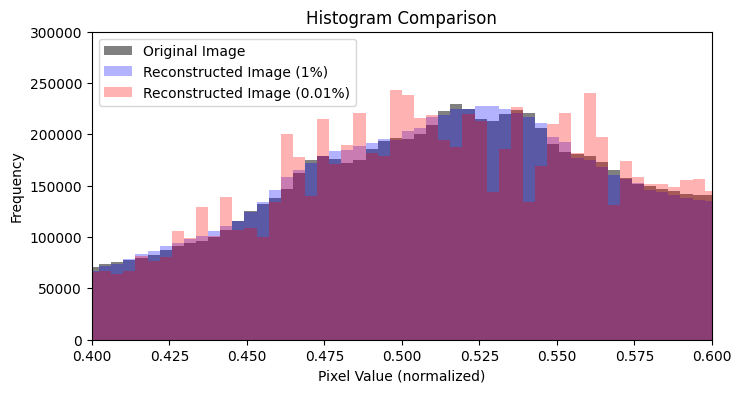

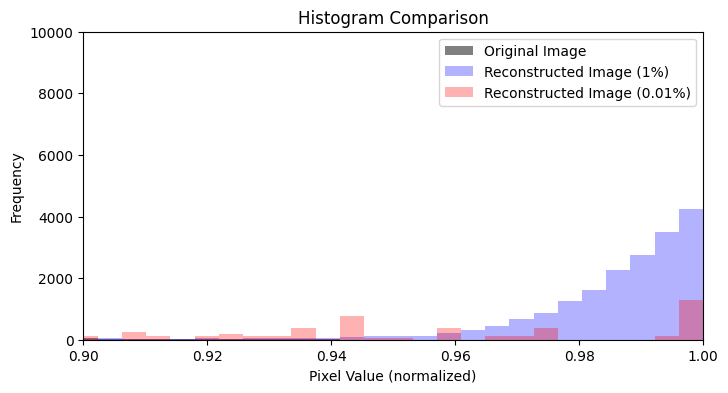

In [13]:
import matplotlib.pyplot as plt

# Combine the two histogram plots into one
def plot_combined_histograms(image, reconstruction1, reconstruction2, xrange=[0.4, 0.6], yrange=[0, 300000]):
    flattened_image = image.flatten()
    flattened_r1_image = reconstruction1.flatten()
    flattened_r2_image = reconstruction2.flatten()

    # Scale to 0~1
    flattened_image = flattened_image / 255.0
    flattened_r1_image = flattened_r1_image / 255.0
    flattened_r2_image = flattened_r2_image / 255.0

    # Plotting the histogram of original image and reconstructed images
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(flattened_image, bins=256, range=[0, 1], density=False, color='grey', alpha=1, label='Original Image')
    ax.hist(flattened_r1_image, bins=256, range=[0, 1], density=False, color='blue', alpha=0.3, label='Reconstructed Image (1%)')
    ax.hist(flattened_r2_image, bins=256, range=[0, 1], density=False, color='red', alpha=0.3, label='Reconstructed Image (0.01%)')
    ax.set_title('Histogram Comparison')
    ax.set_xlabel('Pixel Value (normalized)')
    ax.set_ylabel('Frequency')
    ax.legend()
    plt.xlim(xrange[0], xrange[1])
    plt.ylim(yrange[0], yrange[1])
    #modify ylim so that appropriately, as the x lim changes and hence the range of y value change
    plt.show()
plot_combined_histograms(cropped_original_image, cropped_reconstructed_images["1%"], cropped_reconstructed_images["0.01%"], xrange=[0, 1])
plot_combined_histograms(cropped_original_image, cropped_reconstructed_images["1%"], cropped_reconstructed_images["0.01%"], xrange=[0., 0.1], yrange=[0, 50000])
plot_combined_histograms(cropped_original_image, cropped_reconstructed_images["1%"], cropped_reconstructed_images["0.01%"], xrange=[0.4, 0.6])
plot_combined_histograms(cropped_original_image, cropped_reconstructed_images["1%"], cropped_reconstructed_images["0.01%"], xrange=[0.9, 1.0], yrange=[0, 10000])


Analysis : Mean, std of pixel vaelus vs compression percentage
* 먼저 평균의 경우, compressino이 많이 진행될수록 (즉, x 축 왼쪽으로 갈수록), 평균 픽셀값이 덜어지는 것을 볼 수 있습니다. 평균값에서 멀어지는 것은
* 하지만, 평균값이 압축율이 1e-4가 되어서야만 떨어지기 시작하는 것을 볼 수 있습니다. 이는 haar wavelet 자체가 모든 픽셀에 똑같은 비중을 두는, 평균을 통해서 coarse feature을 뽑아내기 때문에 pixel평균값들이 잘 보존되는 것 같습니다. 
* std의 경우 => 이거 왜이런지 모르겠어요.. 쌤들이랑 논의해보면 좋을수도?

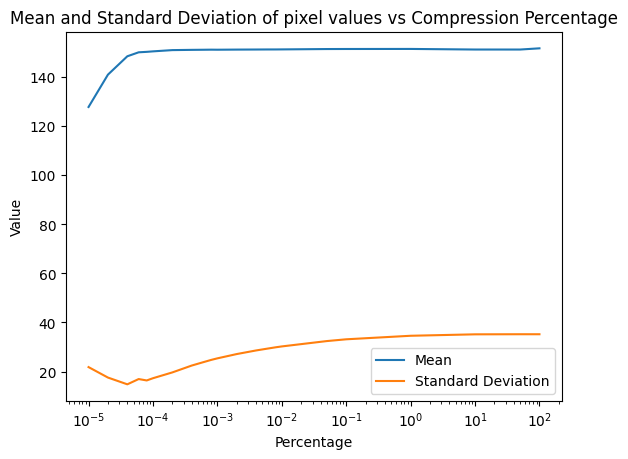

In [14]:
import matplotlib.pyplot as plt

# calculate the mean and std of the images
means = []
stds = []

means.append(cropped_original_image.mean())
stds.append(cropped_original_image.std())

for percentage, cropped_img in cropped_reconstructed_images.items():
    percentage = float(percentage.strip('%'))
    means.append(cropped_img.mean())
    stds.append(cropped_img.std())

# plot the mean and std
percentages = [100] + [float(percentage.strip('%')) for percentage in cropped_reconstructed_images.keys()]

plt.plot(percentages, means, label='Mean')
plt.plot(percentages, stds, label='Standard Deviation')

plt.xlabel('Percentage')
plt.ylabel('Value')
plt.title('Mean and Standard Deviation of pixel values vs Compression Percentage')
plt.legend()
plt.xscale('log')

plt.show()
